In [1]:
import numpy as np
import Loader
import Transformer

C:\Users\Lemon\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
#note loading data also shuffles order of the data
compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

### Notes on Principal Component Analysis

Does it make sense to run PCA on like-type parts of the data?
As there are clearly different "sets" of the data per row.

In [3]:
#for i in range(len(labelsTrain)):
#    print(i, '\b:\t', labelsTrain[i], compoundDataTrain[35:40, i])
    
#for all the following ranges begin is inclusive and end is not inclusive
#[0:10] docking_score_? (0-9)
#[10:20] fusion_score_? (0-9)
#[37:45] bcut2d_? (8 in total)
#[47:59] chi? (12, odd labels)
#[65:79] paoe_vsa? (1-14)
#[79:89] smr_vsa? (1-10)
#[89:101] slogp_vsa? (1-12)
#[102:113] estate_vsa? (1-11)
#[113:123] vsa_estate? (1-10)
#[143:228] fr_some_chemical? (85 total)

#print(labelsTrain[0:10],"\n")
#print(labelsTrain[10:20],"\n")
#print(labelsTrain[37:45],"\n")
#print(labelsTrain[47:59],"\n")
#print(labelsTrain[65:79],"\n")
#print(labelsTrain[79:89],"\n")
#print(labelsTrain[89:101],"\n")
#print(labelsTrain[102:113],"\n")
#print(labelsTrain[113:123],"\n")
#print(labelsTrain[143:228],"\n")

## Data Preprocessing
PCA, modify fusion/docking, normalization

### Apply Principal Component Analysis

In [24]:
#reduce dimension through PCA
#in order endDims sections are chi, paoe, smr, slogp, estate_vsa, vsa_estate, fr
labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  compoundDataTrain, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,2,8,5,6,8,4,16])
print("PCA done, new dimensions:", len(labelsPCA))

bcut2d retention: [0.99364773]
	total: 99.36477273412314%
chi retention: [0.9541968  0.02524522]
	total: 97.94420208614241%
paoe retention: [0.31495127 0.19509321 0.1390042  0.08838179 0.07155396 0.04590061
 0.03243    0.02673268]
	total: 91.40477459559165%
smr retention: [0.50634726 0.24568468 0.08792319 0.07435827 0.03943113]
	total: 95.37445211162546%
slogp retention: [0.44620276 0.22134465 0.15753302 0.04213752 0.03159298 0.02850562]
	total: 92.73165471968963%
estate_vsa retention: [0.29224011 0.18964809 0.14361318 0.10642656 0.07394495 0.06391846
 0.05513575 0.04672882]
	total: 97.16559282999316%
vsa_estate retention: [0.49255304 0.32866098 0.09719245 0.03637439]
	total: 95.47808596198051%
fr retention: [0.32153498 0.12578177 0.09944384 0.0570485  0.05494644 0.04503917
 0.03646285 0.02896244 0.02597271 0.02289905 0.01957315 0.01726897
 0.01514302 0.01174692 0.01137905 0.00991643]
	total: 90.31193140778346%
PCA done, new dimensions: 116


### Use either mean or max magnitude of docking and fusion

Actually quite similar e.g. for the first 3 rows:

fusion max:  $[5.3211, 5.3258, 5.3936]$

fusion avg:  $[5.0530, 5.2303, 5.1805]$

docking max: $[6.7, 7.2, 7.3]$

docking avg: $[-6.51, -6.92, -7.18]$

In [25]:
#use mean of the docking and fusion
labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
_, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
_, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)
print("Mean of Fusion and Docking, new dimensions: ", len(labelsMeanPCA))

Mean of Fusion and Docking, new dimensions:  98


In [26]:
#use max magnitude of the docking and fusion
labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
_, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
_, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)
print("Max of Fusion and Docking, new dimensions: ", len(labelsMeanPCA))

Max of Fusion and Docking, new dimensions:  98


### Assign final data and normalize data

In [27]:
#after transformations are done assign data
dataLabels = labelsMeanPCA
trainData = trainMeanPCA
testData = testMeanPCA
valData = valMeanPCA

trainData, testData, valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)

## See modified labels and example data:

In [28]:
print(np.shape(trainData))
for i in range(len(dataLabels)):
    print(i, "\b:\t", dataLabels[i], "\t", trainData[0:3,i])

(2717, 98)
0 :	 docking_score_average 	 [-0.71717356 -0.07855923 -0.83121183]
1 :	 fusion_score_average 	 [0.88393502 1.30194318 0.97838269]
2 :	 maxestateindex 	 [0.62029659 0.77946105 0.91522625]
3 :	 minestateindex 	 [-0.57521598  0.29535593  0.21697139]
4 :	 maxabsestateindex 	 [0.62029659 0.77946105 0.91522625]
5 :	 minabsestateindex 	 [-0.6254313  -0.50828842 -0.39055761]
6 :	 qed 	 [ 0.1732252   0.39941259 -1.44430893]
7 :	 molwt 	 [0.47702297 0.30324855 1.69236091]
8 :	 heavyatommolwt 	 [0.48203841 0.29567169 1.66653513]
9 :	 exactmolwt 	 [0.47958118 0.30156951 1.69075924]
10 :	 numvalenceelectrons 	 [0.58588692 0.28503419 1.7033399 ]
11 :	 numradicalelectrons 	 [0. 0. 0.]
12 :	 maxpartialcharge 	 [-0.01918824 -0.01918824 -0.01918824]
13 :	 minpartialcharge 	 [-0.91970977 -0.88605919 -0.2589737 ]
14 :	 maxabspartialcharge 	 [-0.01918824 -0.01918824 -0.01918824]
15 :	 minabspartialcharge 	 [-0.20314102 -0.7116252   1.78707331]
16 :	 fpdensitymorgan1 	 [ 1.405781

# Apply NN

In [29]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

In [31]:
#note the constant guess:
classify = Transformer.toBinaryClassification(activitiesTrain)
constantGuess = (len(classify[classify == 1]))/len(classify)
print(constantGuess)

0.6198012513801987


In [ ]:
classTrain = Transformer.toBinaryClassification(activitiesTrain)
classVal = Transformer.toBinaryClassification(activitiesValidate)
classTest = Transformer.toBinaryClassification(activitiesTest)
inputDim = len(dataLabels)


l1Reg = keras.regularizers.L1(.001)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(trainData, classTrain, 
                    validation_data = (valData, classVal), epochs=1600, batch_size=4)

Epoch 1/1600
680/680 [==============================] - 4s 4ms/step - loss: 2.2652 - accuracy: 0.8322 - val_loss: 0.8460 - val_accuracy: 0.8529
Epoch 2/1600
680/680 [==============================] - 2s 3ms/step - loss: 0.6621 - accuracy: 0.8936 - val_loss: 0.5775 - val_accuracy: 0.8912
Epoch 3/1600
680/680 [==============================] - 2s 3ms/step - loss: 0.5295 - accuracy: 0.8977 - val_loss: 0.5182 - val_accuracy: 0.8971
Epoch 4/1600
680/680 [==============================] - 2s 3ms/step - loss: 0.4610 - accuracy: 0.9102 - val_loss: 0.4683 - val_accuracy: 0.8912
Epoch 5/1600
680/680 [==============================] - 2s 3ms/step - loss: 0.4088 - accuracy: 0.9183 - val_loss: 0.4426 - val_accuracy: 0.8912
Epoch 6/1600
680/680 [==============================] - 2s 3ms/step - loss: 0.3926 - accuracy: 0.9220 - val_loss: 0.4246 - val_accuracy: 0.8971
Epoch 7/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.3666 - accuracy: 0.9312 - val_loss: 0.4147 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


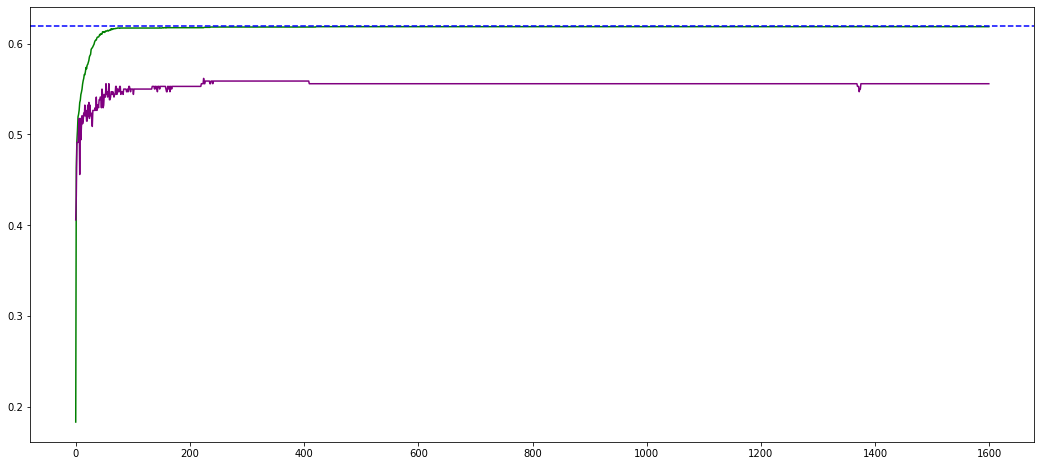

In [27]:
import matplotlib.pyplot as plt

print(history.history.keys())

classify = Transformer.toClassification(activitiesTrain)
constantGuess = (len(classify[classify == 1]))/len(classify)


fig, ax = plt.subplots(figsize=(18,8))

ax.plot(history.history["accuracy"], color="green")
ax.plot(history.history["val_accuracy"], color="purple")
ax.axhline(constantGuess, color="blue", linestyle="dashed")

In [73]:
classData = Transformer.toClassification(activitiesTrain)
print(len(trainData))
print(len(classData[classData == 1]))
print(len(classData[classData != 1]))

2717
1684
1033
